<a href="https://colab.research.google.com/github/EdgarNH29/Ciencia-de-Datos-para-Sensores-Inteligentes/blob/main/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencia de datos para sensores inteligentes

# Practica 2 Sensado y analisis de video
## Edgar Nava Hernandez

El objetivo de este notebook es realizar el procesamiento, normalización y preparación del dataset previamente generado, así como el entrenamiento de los modelos de clasificación para el reconocimiento de marcha. En esta etapa se trabaja únicamente con los datos ya estructurados, enfocándose en ajustar y entrenar los modelos para que aprendan los patrones de movimiento de cada persona. Se realizaron pruebas utilizando el conjunto de videos de prueba proporcionado por los profesores, con el fin de observar el comportamiento y la capacidad de generalización de los modelos ante datos no vistos. Cabe mencionar que la creación del dataset se realizó de manera local en Python, y no en Google Colab, debido a la gran cantidad y tamaño de los videos, lo que hacía más eficiente su procesamiento fuera de la nube.

# Preprocesar dataset

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

CSV_PATH = "dataset_pose.csv"

WINDOW = 30
STRIDE = 2

LANDMARKS = [
    11,12,   # hombros
    13,14,   # codos
    15,16,   # muñecas
    23,24,   # caderas
    25,26,   # rodillas
    27,28    # tobillos
]
df = pd.read_csv(CSV_PATH)

In [ ]:

df = df[df["landmark_id"].isin(LANDMARKS)]
df = df.sort_values(["persona", "video_id", "frame"])

Mapeo de clases

In [ ]:
personas = sorted(df["persona"].unique())
label_map = {p: i for i, p in enumerate(personas)}

print("\nPersonas detectadas:")
print(label_map)



Personas detectadas:
{'Diana_Itzel': 0, 'Diana_Minerva': 1, 'Edgar': 2, 'Erick': 3, 'Hussein': 4, 'Ian': 5, 'Javier': 6, 'Joan': 7, 'Jose': 8, 'Mariel': 9, 'Norman': 10, 'Tony': 11, 'Zarif': 12}


Guardar etiquetas para evaluaciones futuras

In [ ]:
with open("labels.txt", "w", encoding="utf-8") as f:
    for p in personas:
        f.write(p + "\n")
print("labels.txt guardado")

labels.txt guardado


Agrupar por video

In [ ]:
groups = df.groupby(["persona", "video_id"])


Crear secuencias

In [ ]:
def crear_secuencias(video_list):
    X, y = [], []

    for (persona, vid) in tqdm(video_list):
        g = groups.get_group((persona, vid))
        frames = sorted(g["frame"].unique())
        frame_data = []

        for fr in frames:
            sub = g[g["frame"] == fr]
            if len(sub) != len(LANDMARKS):
                continue

            coords = []
            for lm in LANDMARKS:
                row = sub[sub["landmark_id"] == lm].iloc[0]
                coords.append([row.x, row.y, row.z])
            coords = np.array(coords, dtype=np.float32)

            hip_center = coords[6:8].mean(axis=0)
            coords -= hip_center
            scale = np.linalg.norm(coords[0] - coords[1]) + 1e-6
            coords /= scale

            frame_data.append(coords.flatten())

        frame_data = np.array(frame_data)

        for i in range(0, len(frame_data) - WINDOW, STRIDE):
            X.append(frame_data[i:i+WINDOW])
            y.append(label_map[persona])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)


Procesar datos de entrenamiento

In [ ]:
train_videos = list(groups.groups.keys())

print("\nCreando TRAIN...")
X_train, y_train = crear_secuencias(train_videos)


Creando TRAIN...


100%|██████████| 52/52 [00:20<00:00,  2.58it/s]


Guardar matrices de caracteristicas

In [ ]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

print("\nShapes finales:")
print("Train:", X_train.shape)

from collections import Counter
print("\nDistribución:")
print("Train:", Counter(y_train))


Shapes finales:
Train: (2348, 30, 36)

Distribución:
Train: Counter({np.int32(11): 306, np.int32(3): 271, np.int32(2): 254, np.int32(8): 211, np.int32(4): 202, np.int32(10): 175, np.int32(7): 169, np.int32(0): 151, np.int32(5): 145, np.int32(6): 141, np.int32(1): 129, np.int32(12): 104, np.int32(9): 90})


# Entrenar modelo LSTM

En este código cargué los datos de entrenamiento desde archivos .npy, donde X_train contiene secuencias de 30 pasos de tiempo con 36 características cada una y y_train sus respectivas etiquetas. Después construí un modelo secuencial con Keras usando capas LSTM, ya que este tipo de red es adecuada para datos temporales porque puede aprender patrones a lo largo del tiempo. Coloqué una primera LSTM de 128 neuronas para extraer características de la secuencia completa, apliqué Dropout para reducir el sobreajuste y añadí una segunda LSTM de 64 neuronas para resumir la información. Luego agregué capas densas para realizar la clasificación final con softmax, obteniendo la probabilidad de cada clase. Finalmente compilé el modelo con el optimizador Adam, lo entrené durante 30 épocas usando parte de los datos para validación y guardé el modelo resultante en un archivo .h5 para poder reutilizarlo después sin necesidad de volver a entrenarlo.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

num_classes = len(np.unique(y_train))

model = keras.Sequential([
    layers.Input(shape=(30, 36)),

    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),

    layers.LSTM(64),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

model.save("modelo.h5")
print("Modelo guardado como modelo.h5")


Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2354 - loss: 2.2599 - val_accuracy: 0.2255 - val_loss: 3.9480
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7256 - loss: 0.9146 - val_accuracy: 0.2511 - val_loss: 4.8952
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8850 - loss: 0.4081 - val_accuracy: 0.2553 - val_loss: 5.6018
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9428 - loss: 0.1872 - val_accuracy: 0.1957 - val_loss: 6.2052
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9650 - loss: 0.1390 - val_accuracy: 0.3489 - val_loss: 5.9960
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9939 - loss: 0.0344 - val_accuracy: 0.4043 - val_loss: 6.1163
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9855 - loss: 0.0505 - val_accuracy: 0.3787 - val_loss: 5.9999
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9853 - loss: 0.0543 - val_accuracy: 0.3830 - v

Modelo guardado como modelo.h5


# Evaluar modelo LSTM (solo el conjunto de entrenamiento)

En esta parte realicé la evaluación del modelo entrenado cargando primero el archivo modelo.h5 junto con los datos de prueba y sus etiquetas. Después verifiqué las dimensiones de X y y para asegurarme de que coincidieran con el formato esperado por la red. También leí el archivo labels.txt para obtener los nombres de las clases y poder interpretar mejor los resultados. Con el modelo cargado, generé las predicciones usando model.predict() y seleccioné la clase con mayor probabilidad mediante argmax. Posteriormente calculé métricas de desempeño como accuracy, F1 macro y F1 weighted, que permiten medir qué tan bien clasifica el modelo tanto de forma general como considerando el balance entre clases. Además, imprimí el classification report para observar precisión, recall y F1 por clase, y finalmente construí una matriz de confusión visualizada con un mapa de calor para identificar en qué clases el modelo se equivoca con mayor frecuencia.

Cargando modelo...
Shape X: (2348, 30, 36)
Shape y: (2348,)
Clases: ['Diana_Itzel', 'Diana_Minerva', 'Edgar', 'Erick', 'Hussein', 'Ian', 'Javier', 'Joan', 'Jose', 'Mariel', 'Norman', 'Tony', 'Zarif']

Accuracy: 0.9408
F1 macro: 0.8892
F1 weighted: 0.921

Classification Report:

               precision    recall  f1-score   support

  Diana_Itzel     0.9679    1.0000    0.9837       151
Diana_Minerva     0.9627    1.0000    0.9810       129
        Edgar     0.9695    1.0000    0.9845       254
        Erick     0.9855    1.0000    0.9927       271
      Hussein     0.9665    1.0000    0.9830       202
          Ian     0.9732    1.0000    0.9864       145
       Javier     0.7663    1.0000    0.8677       141
         Joan     0.7682    1.0000    0.8689       169
         Jose     0.9462    1.0000    0.9724       211
       Mariel     1.0000    1.0000    1.0000        90
       Norman     1.0000    1.0000    1.0000       175
         Tony     1.0000    0.8856    0.9393       306
     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


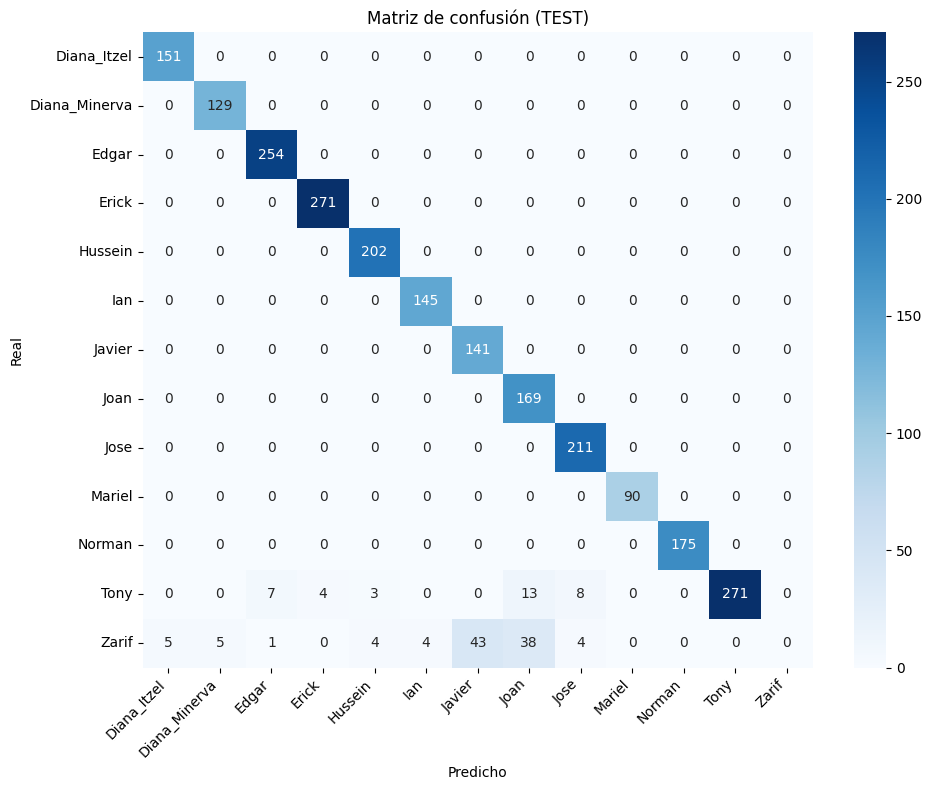

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

MODEL_PATH = "modelo.h5"
X_TEST_PATH = "X_train.npy"
Y_TEST_PATH = "y_train.npy"
LABELS_FILE = "labels.txt"

print("Cargando modelo...")
model = load_model(MODEL_PATH)

X = np.load(X_TEST_PATH)
y = np.load(Y_TEST_PATH)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

with open(LABELS_FILE, "r", encoding="utf-8") as f:
    class_names = [line.strip() for line in f]

print("Clases:", class_names)

y_pred_probs = model.predict(X, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = (y_pred == y).mean()
f1_macro = f1_score(y, y_pred, average="macro")
f1_weighted = f1_score(y, y_pred, average="weighted")

print("\n==============================")
print("Accuracy:", round(accuracy, 4))
print("F1 macro:", round(f1_macro, 4))
print("F1 weighted:", round(f1_weighted, 4))
print("==============================")

print("\nClassification Report:\n")
print(classification_report(y, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha="right")
plt.title("Matriz de confusión (TEST)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


En esta fase evalué el modelo utilizando videos externos en formato .bag que no están etiquetados, por lo que no fue posible calcular métricas tradicionales como accuracy o F1-score. Primero cargué el modelo entrenado y los nombres de las clases, y después utilicé MediaPipe Pose para detectar los landmarks del cuerpo en cada frame del video. De cada imagen extraje 12 puntos clave y sus coordenadas, los normalicé respecto al centro de la cadera y la escala del cuerpo para hacer las secuencias invariantes a posición y tamaño. Luego formé ventanas deslizantes de 30 frames, generando secuencias con el mismo formato que el entrenamiento, y las pasé al modelo para obtener predicciones. Como cada video produce muchas secuencias, promedié las probabilidades para obtener una predicción global por video y calculé un nivel de confianza (alta, media o baja) según umbrales definidos. Finalmente, mostré la clase estimada y la distribución de probabilidades, lo que permite analizar el comportamiento del modelo aunque no se cuente con etiquetas reales.

In [ ]:
!pip install pyrealsense2
!pip install mediapipe
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
import cv2
import pyrealsense2 as rs
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os

MODEL_PATH = "modelo.h5"
POSE_MODEL = "pose_landmarker.task"
TEST_PATH = "drive/MyDrive/CDSI 2026/Imagen/test/validacion externa"

SEQ_LEN = 30
MP_WIDTH = 640
MP_HEIGHT = 360

HIGH_TH = 0.65
MID_TH = 0.50

LANDMARKS = [11,12,13,14,15,16,23,24,25,26,27,28]


Cargar modelo

In [ ]:
print("Cargando modelo...")
model = load_model(MODEL_PATH)
print("Input esperado por modelo:", model.input_shape)

with open("labels.txt", "r", encoding="utf-8") as f:
    clases = [line.strip() for line in f]

print("Clases conocidas:", clases)

Cargando modelo...
Input esperado por modelo: (None, 30, 36)
Clases conocidas: ['Diana_Itzel', 'Diana_Minerva', 'Edgar', 'Erick', 'Hussein', 'Ian', 'Javier', 'Joan', 'Jose', 'Mariel', 'Norman', 'Tony', 'Zarif']


Mediapipe

In [ ]:
base_options = python.BaseOptions(model_asset_path=POSE_MODEL)

options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE
)

detector = vision.PoseLandmarker.create_from_options(options)


Interpretar confianza en la deteccion de clases en los videos de prueba

In [62]:
def interpretar_confianza(c):
    if c >= HIGH_TH:
        return "ALTA"
    elif c >= MID_TH:
        return "MEDIA"
    else:
        return "BAJA"

def procesar_bag(bag_path):
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, bag_path, repeat_playback=False)

    profile = pipeline.start(config)
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)

    align = rs.align(rs.stream.color)

    buffer_seq = []
    sequences = []

    print("Procesando...")

    while True:
        try:
            frames = pipeline.wait_for_frames()
        except RuntimeError:
            break

        aligned = align.process(frames)
        depth = aligned.get_depth_frame()
        color = aligned.get_color_frame()

        if not depth or not color:
            continue

        color_img = np.asanyarray(color.get_data())
        small = cv2.resize(color_img, (MP_WIDTH, MP_HEIGHT))

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
        )

        result = detector.detect(mp_image)

        if not result.pose_landmarks:
            continue

        pose = result.pose_landmarks[0]

        frame_landmarks = []
        for idx in LANDMARKS:
            lm = pose[idx]
            px = int(lm.x * depth.get_width())
            py = int(lm.y * depth.get_height())

            if 0 <= px < depth.get_width() and 0 <= py < depth.get_height():
                z = depth.get_distance(px, py)
            else:
                z = 0

            frame_landmarks.extend([lm.x, lm.y, z])

        # Normalizacion
        coords = np.array(frame_landmarks, dtype=np.float32).reshape(-1,3)
        hip_center = coords[6:8].mean(axis=0)
        coords -= hip_center
        scale = np.linalg.norm(coords[0] - coords[1]) + 1e-6
        coords /= scale
        frame_landmarks = coords.flatten().tolist()

        buffer_seq.append(frame_landmarks)

        if len(buffer_seq) == SEQ_LEN:
            sequences.append(buffer_seq.copy())
            buffer_seq.pop(0)

    pipeline.stop()

    if len(sequences) == 0:
        return None, 0, None

    X = np.array(sequences, dtype=np.float32)
    print("Shape generado:", X.shape)

    # Predicción
    probs = model.predict(X, verbose=0)
    mean_probs = probs.mean(axis=0)

    best_idx = np.argmax(mean_probs)
    confidence = float(mean_probs[best_idx])

    return clases[best_idx], confidence, mean_probs


Buscar los videos en drive

In [67]:
bag_files = []
for root, _, files in os.walk(TEST_PATH):
    for f in files:
        if f.endswith(".bag"):
            bag_files.append(os.path.join(root, f))

print(f"\nSe encontraron {len(bag_files)} videos\n")



Se encontraron 12 videos



por error hice una copia de todos los videos en drive y despues la borre pero como siguen en la pa

Prueba

In [97]:
for bag in bag_files:
    print("\n======================================")
    print("Video:", bag)

    label, conf, dist = procesar_bag(bag)

    if label is None:
        print("Sin poses detectadas")
        continue

    print("Predicción:", label)
    print(f"Confianza: {conf*100:.2f}%  |  {interpretar_confianza(conf)}")
    print("Distribución:", np.round(dist, 3))


Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_163749.bag
Procesando...
Shape generado: (38, 30, 36)
Predicción: Norman
Confianza: 59.99%  |  MEDIA
Distribución: [0.    0.    0.    0.    0.065 0.002 0.018 0.05  0.109 0.145 0.6   0.001
 0.01 ]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_164242.bag
Procesando...
Shape generado: (63, 30, 36)
Predicción: Tony
Confianza: 70.49%  |  ALTA
Distribución: [0.003 0.    0.    0.    0.044 0.    0.007 0.184 0.007 0.008 0.008 0.705
 0.033]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_164008.bag
Procesando...
Shape generado: (79, 30, 36)
Predicción: Hussein
Confianza: 60.78%  |  MEDIA
Distribución: [0.001 0.003 0.    0.    0.608 0.    0.018 0.08  0.003 0.278 0.003 0.
 0.006]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_163934.bag
Procesando...
Shape generado: (82, 30, 36)
Predicción: Hussein
Confianza: 43.4

Al evaluar el modelo con los videos del conjunto de prueba externo, observé su desempeño directamente reproduciendo cada secuencia para comparar visualmente las predicciones. Noté que algunos videos presentan ruido, como cambios de postura o movimientos adicionales, lo que puede dificultar la clasificación y afectar la confianza del modelo. Aun así, en varios casos donde aparecieron personas que no formaban parte del conjunto de entrenamiento, el modelo logró asignarlas a clases coherentes debido a que compartían características de movimiento similares, lo que indica cierta capacidad de generalización. En los videos correspondientes a sujetos conocidos, el sistema identificó correctamente la caminata de Tony y Joan en distintas ocasiones. En general, el modelo mostró un desempeño satisfactorio, aunque los resultados evidencian que la variabilidad y el ruido en los datos pueden influir en la precisión.



Enaluar modelo CNN 1D

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


Cargar dataset

In [73]:
CSV_PATH = "dataset_pose.csv"

df = pd.read_csv(CSV_PATH)
df.head()


,persona,video_id,frame,landmark_id,x,y,z
0,Diana_Itzel,0,13,0,0.432504,0.333129,10.260
1,Diana_Itzel,0,13,1,0.431475,0.331888,10.104
2,Diana_Itzel,0,13,2,0.431076,0.331366,10.053
3,Diana_Itzel,0,13,3,0.430710,0.330903,10.053
4,Diana_Itzel,0,13,4,0.432195,0.332564,10.260


Codificar etiquetas

In [74]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["persona"])

class_names = le.classes_
num_classes = len(class_names)

print("Clases:", class_names)


Clases: ['Diana_Itzel' 'Diana_Minerva' 'Edgar' 'Erick' 'Hussein' 'Ian' 'Javier'
 'Joan' 'Jose' 'Mariel' 'Norman' 'Tony' 'Zarif']


Construir secuencias

In [77]:
SEQ_LEN = 30

X = []
y = []

grouped = df.groupby(["persona", "video_id"])

for (persona, vid), g in grouped:

    frames = []

    for frame_id, f in g.groupby("frame"):
        coords = (
            f.sort_values("landmark_id")[["x","y","z"]]
            .values
            .flatten()
        )
        frames.append(coords)

    frames = np.array(frames)

    for i in range(len(frames) - SEQ_LEN + 1):
        X.append(frames[i:i+SEQ_LEN])
        y.append(g["label"].iloc[0])

X = np.array(X, dtype=np.float32)
y = np.array(y)

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (4720, 30, 99)
Shape y: (4720,)


Crear datos para entrenamiento

In [101]:
X_trainCNN = X
y_trainCNN = y

print("Datos listos para entrenamiento:", X_trainCNN.shape)

Datos listos para entrenamiento: (4720, 30, 99)


Construir modelo CNN 1D

In [102]:
model = keras.Sequential([

    layers.Input(shape=(SEQ_LEN, X_trainCNN.shape[2])),

    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.MaxPooling1D(2),

    layers.Conv1D(128, kernel_size=3, activation="relu"),
    layers.MaxPooling1D(2),

    layers.GlobalAveragePooling1D(),

    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 28, 64)         │        19,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,877 (206.55 KB)

 Trainable params: 52,877 (206.55 KB)

 Non-trainable params: 0 (0.00 B)

Compilar

In [103]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Entrenar

In [104]:
history = model.fit(
    X_trainCNN,
    y_trainCNN,
    epochs=30,
    batch_size=32,
    shuffle=True
)


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1274 - loss: 2.5555
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1818 - loss: 2.3945
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1993 - loss: 2.3058
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2586 - loss: 2.1159
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3478 - loss: 1.8225
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3799 - loss: 1.6798
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4934 - loss: 1.4059
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5425 - loss: 1.2721
Epoch 9/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5913 - loss: 1.1163
Epoch 10/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6540 - loss: 0.9653
Epoch 11/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6913 - loss: 0.8831
Epoch 12/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Guardar modelo

In [106]:
model.save("cnn1d_model.h5")
print("Modelo guardado como cnn1d_model.h5")

with open("labels.txt", "w", encoding="utf-8") as f:
    for c in class_names:
        f.write(c + "\n")

print("labels.txt guardado")

np.save("X_trainCNN.npy", X_trainCNN)
np.save("y_trainCNN.npy", y_trainCNN)


Modelo guardado como cnn1d_model.h5
labels.txt guardado


# Evaluar conjunto de pruebas con CNN 1D

Configuracion

In [107]:
MODEL_PATH = "cnn1d_model.h5"
POSE_MODEL = "pose_landmarker.task"

TEST_PATH = "drive/MyDrive/CDSI 2026/Imagen/test/validacion externa"

SEQ_LEN = 30
MP_WIDTH = 640
MP_HEIGHT = 360

HIGH_TH = 0.65
MID_TH = 0.50

LANDMARKS = [11,12,13,14,15,16,23,24,25,26,27,28]


Cargar modelo y clases

In [115]:
print("Cargando modelo CNN...")
model = load_model(MODEL_PATH)

print("Input esperado:", model.input_shape)

with open("labels.txt", "r", encoding="utf-8") as f:
    clases = [line.strip() for line in f]

print("Clases:", clases)


Cargando modelo CNN...
Input esperado: (None, 30, 99)
Clases: ['Diana_Itzel', 'Diana_Minerva', 'Edgar', 'Erick', 'Hussein', 'Ian', 'Javier', 'Joan', 'Jose', 'Mariel', 'Norman', 'Tony', 'Zarif']


Inicializar mediapipe pose

In [116]:
base_options = python.BaseOptions(model_asset_path=POSE_MODEL)

options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE
)

detector = vision.PoseLandmarker.create_from_options(options)


Funcion de confianza

In [117]:
def interpretar_confianza(c):
    if c >= HIGH_TH:
        return "ALTA"
    elif c >= MID_TH:
        return "MEDIA"
    else:
        return "BAJA"


Procesar videos

In [121]:
def procesar_bag(bag_path):

    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, bag_path, repeat_playback=False)

    profile = pipeline.start(config)
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)

    align = rs.align(rs.stream.color)

    buffer_seq = []
    sequences = []

    print("Procesando...")

    while True:
        try:
            frames = pipeline.wait_for_frames()
        except RuntimeError:
            break

        aligned = align.process(frames)
        depth = aligned.get_depth_frame()
        color = aligned.get_color_frame()

        if not depth or not color:
            continue

        color_img = np.asanyarray(color.get_data())
        small = cv2.resize(color_img, (MP_WIDTH, MP_HEIGHT))

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
        )

        result = detector.detect(mp_image)

        if not result.pose_landmarks:
            continue

        pose = result.pose_landmarks[0]

        frame_landmarks = []
        # MODIFIED: Iterate over all 33 detected landmarks instead of the 'LANDMARKS' list
        for lm_idx in range(len(pose)):
            lm = pose[lm_idx]

            px = int(lm.x * depth.get_width())
            py = int(lm.y * depth.get_height())

            if 0 <= px < depth.get_width() and 0 <= py < depth.get_height():
                z = depth.get_distance(px, py)
            else:
                z = 0

            frame_landmarks.extend([lm.x, lm.y, z])

        coords = np.array(frame_landmarks, dtype=np.float32).reshape(-1,3)

        # Normalization: Adjusted indices for hip center (landmarks 23 and 24) and shoulders (landmarks 11 and 12)
        # assuming the full 33 MediaPipe landmarks are present in 'coords'
        hip_center = coords[[23, 24]].mean(axis=0) # MediaPipe indices for Left Hip (23), Right Hip (24)
        coords -= hip_center

        scale = np.linalg.norm(coords[11] - coords[12]) + 1e-6 # MediaPipe indices for Left Shoulder (11), Right Shoulder (12)
        coords /= scale

        frame_landmarks = coords.flatten().tolist()

        buffer_seq.append(frame_landmarks)

        if len(buffer_seq) == SEQ_LEN:
            sequences.append(buffer_seq.copy())
            buffer_seq.pop(0)

    pipeline.stop()

    if len(sequences) == 0:
        return None, 0, None

    X = np.array(sequences, dtype=np.float32)

    print("Shape generado:", X.shape)

    probs = model.predict(X, verbose=0)

    mean_probs = probs.mean(axis=0)

    best_idx = np.argmax(mean_probs)
    confidence = float(mean_probs[best_idx])

    return clases[best_idx], confidence, mean_probs

In [122]:
bag_files = []

for root, _, files in os.walk(TEST_PATH):
    for f in files:
        if f.endswith(".bag"):
            bag_files.append(os.path.join(root, f))

print(f"\nSe encontraron {len(bag_files)} videos\n")

for bag in bag_files:

    print("\n======================================")
    print("Video:", bag)

    label, conf, dist = procesar_bag(bag)

    if label is None:
        print("Sin poses detectadas")
        continue

    print("Predicción:", label)
    print(f"Confianza: {conf*100:.2f}% | {interpretar_confianza(conf)}")
    print("Distribución:", np.round(dist, 3))



Se encontraron 12 videos


Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_163749.bag
Procesando...
Shape generado: (38, 30, 99)
Predicción: Javier
Confianza: 78.35% | ALTA
Distribución: [0.    0.    0.    0.    0.    0.    0.783 0.    0.    0.    0.    0.217
 0.   ]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_164242.bag
Procesando...
Shape generado: (63, 30, 99)
Predicción: Tony
Confianza: 64.11% | MEDIA
Distribución: [0.    0.    0.    0.    0.    0.    0.359 0.    0.    0.    0.    0.641
 0.   ]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_164008.bag
Procesando...
Shape generado: (79, 30, 99)
Predicción: Tony
Confianza: 70.81% | ALTA
Distribución: [0.    0.    0.    0.    0.    0.    0.292 0.    0.    0.    0.    0.708
 0.   ]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_163934.bag
Procesando...
Shape generado: (82, 30, 99)
Predicción: Ton

Al evaluar el modelo CNN 1D se observó que la red tendió a concentrar la mayoría de sus predicciones únicamente en dos clases, principalmente Tony y Javier, asignando probabilidades muy bajas o nulas al resto de las personas.

Esto contrasta con el comportamiento del modelo LSTM, el cual mostró una distribución de probabilidades más variada entre diferentes clases y fue capaz de identificar a más personas del conjunto de prueba.

Este comportamiento puede explicarse por las diferencias de las arquitecturas entre ambos modelos. La CNN 1D aprende patrones locales mediante filtros convolucionales que detectan movimientos o cambios pequeños entre frames consecutivos, pero no modela de forma explícita las dependencias temporales largas de la secuencia completa. En problemas como el reconocimiento de la marcha, donde el patrón global del movimiento a lo largo del tiempo es importante, esta limitación puede provocar que la red aprenda características más generales y termine agrupando comportamientos similares en pocas clases dominantes.

# Evaluar conjunto de pruebas con SVM

## Cargar dataset y evaluar datos
Usamos las mismas secuencias que LSTM pero svm las usa de diferente manera

In [126]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import joblib

X = np.load("X_train.npy")
y = np.load("y_train.npy")

print("Shape original:", X.shape)

X_flat = X.reshape(X.shape[0], -1)

print("Shape para SVM:", X_flat.shape)


Shape original: (2348, 30, 36)
Shape para SVM: (2348, 1080)


Normalizar

In [127]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)


Entrenar modelo svm

In [128]:
svm = SVC(
    kernel="rbf",
    probability=True,
    C=10,
    gamma="scale"
)

print("Entrenando SVM...")
svm.fit(X_scaled, y)

print("Modelo entrenado")


Entrenando SVM...
Modelo entrenado


Guardar modelo

In [129]:
joblib.dump(svm, "svm_model.pkl")
joblib.dump(sampler := scaler, "svm_scaler.pkl")

print("SVM guardado")


SVM guardado


Probar modelo

Configuracion

In [130]:
SVM_PATH = "svm_model.pkl"
SCALER_PATH = "svm_scaler.pkl"
POSE_MODEL = "pose_landmarker.task"
TEST_PATH = "drive/MyDrive/CDSI 2026/Imagen/test/validacion externa"
LABELS_FILE = "labels.txt"

SEQ_LEN = 30
MP_WIDTH = 640
MP_HEIGHT = 360

HIGH_TH = 0.65
MID_TH  = 0.50

LANDMARKS = [11,12,13,14,15,16,23,24,25,26,27,28]


Cargar modelo

In [132]:
svm = joblib.load(SVM_PATH)
scaler = joblib.load(SCALER_PATH)

with open(LABELS_FILE, "r", encoding="utf-8") as f:
    clases = [line.strip() for line in f]

print("Clases:", clases)


Clases: ['Diana_Itzel', 'Diana_Minerva', 'Edgar', 'Erick', 'Hussein', 'Ian', 'Javier', 'Joan', 'Jose', 'Mariel', 'Norman', 'Tony', 'Zarif']


In [134]:
def procesar_bag(bag_path):

    pipeline = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, bag_path, repeat_playback=False)

    profile = pipeline.start(config)
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)

    align = rs.align(rs.stream.color)

    buffer_seq = []
    sequences = []

    print("Procesando...")

    while True:
        try:
            frames = pipeline.wait_for_frames()
        except RuntimeError:
            break

        aligned = align.process(frames)
        depth = aligned.get_depth_frame()
        color = aligned.get_color_frame()

        if not depth or not color:
            continue

        color_img = np.asanyarray(color.get_data())
        small = cv2.resize(color_img, (MP_WIDTH, MP_HEIGHT))

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
        )

        result = detector.detect(mp_image)

        if not result.pose_landmarks:
            continue

        pose = result.pose_landmarks[0]

        frame_landmarks = []

        for idx in LANDMARKS:
            lm = pose[idx]

            px = int(lm.x * depth.get_width())
            py = int(lm.y * depth.get_height())

            if 0 <= px < depth.get_width() and 0 <= py < depth.get_height():
                z = depth.get_distance(px, py)
            else:
                z = 0

            frame_landmarks.extend([lm.x, lm.y, z])

            coords = np.array(frame_landmarks, dtype=np.float32).reshape(-1,3)

        hip_center = coords[6:8].mean(axis=0)
        coords -= hip_center

        scale = np.linalg.norm(coords[0] - coords[1]) + 1e-6
        coords /= scale

        buffer_seq.append(coords.flatten())

        if len(buffer_seq) == SEQ_LEN:
            sequences.append(buffer_seq.copy())
            buffer_seq.pop(0)

    pipeline.stop()

    if len(sequences) == 0:
        return None

    return sequences




Prediccion SVM

In [135]:
def predecir_svm(sequences):

    X = np.array(sequences, dtype=np.float32)

    X = X.reshape(X.shape[0], -1)

    X = scaler.transform(X)

    probs = svm.predict_proba(X)

    mean_probs = probs.mean(axis=0)

    best_idx = np.argmax(mean_probs)
    confidence = float(mean_probs[best_idx])

    return clases[best_idx], confidence, mean_probs

In [137]:
bag_files = []

for root, _, files in os.walk(TEST_PATH):
    for f in files:
        if f.endswith(".bag"):
            bag_files.append(os.path.join(root, f))

print(f"\nSe encontraron {len(bag_files)} videos\n")


for bag in bag_files:

    print("\n======================================")
    print("Video:", bag)

    sequences = procesar_bag(bag)

    if sequences is None:
        print("Sin poses detectadas")
        continue

    label, conf, dist = predecir_svm(sequences)

    print("Predicción:", label)
    print(f"Confianza: {conf*100:.2f}% | {interpretar_confianza(conf)}")
    print("Distribución:", np.round(dist, 3))


Se encontraron 12 videos


Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_163749.bag
Procesando...
Predicción: Jose
Confianza: 30.08% | BAJA
Distribución: [0.097 0.156 0.007 0.007 0.13  0.008 0.037 0.009 0.301 0.131 0.02  0.006
 0.09 ]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_164242.bag
Procesando...
Predicción: Tony
Confianza: 24.71% | BAJA
Distribución: [0.069 0.008 0.015 0.01  0.107 0.006 0.09  0.026 0.211 0.015 0.026 0.247
 0.169]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_164008.bag
Procesando...
Predicción: Jose
Confianza: 56.76% | MEDIA
Distribución: [0.168 0.034 0.004 0.005 0.037 0.005 0.01  0.007 0.568 0.009 0.028 0.004
 0.121]

Video: drive/MyDrive/CDSI 2026/Imagen/test/validacion externa/grabacion_20260206_163934.bag
Procesando...
Predicción: Jose
Confianza: 56.98% | MEDIA
Distribución: [0.098 0.029 0.043 0.012 0.021 0.008 0.009 0.004 0.57  0.006 0.029 0.002
 0.

# Conclusion

El modelo LSTM presentó el mejor comportamiento general, ya que fue capaz de capturar la dinámica temporal completa de la caminata. Debido a que este tipo de red está diseñada específicamente para trabajar con secuencias, pudo aprender patrones como el ritmo, la cadencia y la repetición del movimiento, lo que permitió obtener predicciones más consistentes y con mayor confianza. Esto lo convirtió en el modelo más adecuado para el problema de gait recognition.

CNN mostró un desempeño más limitado. Aunque logró aprender ciertas características locales de las señales, tendió a confundirse entre clases y a favorecer algunas personas sobre otras, lo que sugiere un posible sobreajuste. Esto ocurre porque las convoluciones capturan patrones cortos o locales, pero no modelan correctamente la relación temporal completa, que es fundamental en este tipo de datos.

SVM demostró una mejor capacidad de generalización que la CNN, ya que sus predicciones estuvieron más distribuidas entre distintas clases y no se sesgó hacia unas pocas personas. Sin embargo, sus niveles de confianza fueron menores, lo que indica que, aunque separa bien los datos a nivel global, no logra capturar detalles complejos del movimiento como lo hace el LSTM. Su desempeño quedó en un punto intermedio entre ambos modelos.

